In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
# import re
import pylab
import warnings
warnings.filterwarnings("ignore")
#unnamed(1).graphml
DAG = nx.read_graphml("unnamed.graphml")

    Требуется при наличествующем W реализовать распределение по слоям с помощью алгоритма Грэхема—Коффмана. 
    При отсутствующем W нужно реализовать алгоритм минимизации количества dummy-вершин. 

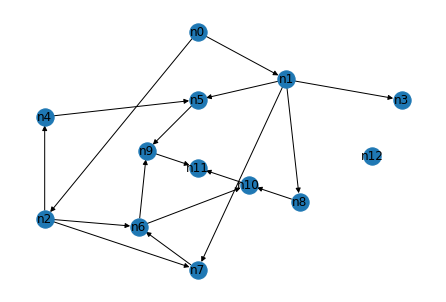

In [2]:
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
# T = nx.balanced_tree(2, 5)

pos = graphviz_layout(DAG, prog="twopi")
nx.draw(DAG, pos, with_labels=True)
plt.show()

In [3]:
# Этап 1
vertices_sorted = list(reversed(list(nx.lexicographical_topological_sort(DAG))))

In [4]:
def get_neighbors(G, parent):
    parents = list(G.predecessors(parent))
    children = list(G.neighbors(parent))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)
    return children, parents

In [5]:
def get_max_P_vertex(v, sets):
#     return max(coffman_graham(DAG), key=coffman_graham(DAG).get)
    max_ = ["", 0]
    for i in sets:
        if v[i] > max_[1]:
            max_[0] = i
            max_[1] = v[i]
    return max_[0]

In [6]:
def get_all_elements_on_layers(L):
    all_layers = set()
    for k, v in L.items():
        all_layers.update(v)
#     for i in range(k-1):
# #         print(L[i])
#         all_layers.update(L[i])
    return all_layers

In [7]:
def coffman_graham(G, W=3):
    '''
    '''
    λ = {}
    vertices_sorted = list(reversed(list(nx.lexicographical_topological_sort(DAG))))
    
    V = set(vertices_sorted)
    
    for i, v in enumerate(vertices_sorted[::-1]):
        λ[v] = i+1
    
    k = 1 # Номер слоя
    U = set() # Множество изначально распределенных по слоям вершины
    L = defaultdict(list) # Множество вершин i-го слоя 
    
    count = 0
    while U != V:
        v_sub_u = V.difference(U)
        u = get_max_P_vertex(λ, v_sub_u)
        
        neighbors = get_neighbors(DAG, u)
       
        L_k = get_all_elements_on_layers(L)
        L_k = L_k.difference(set(L[k]))
        
        if len(L[k]) < W and set(neighbors[0]).issubset(L_k):
            L[k].append(u)
        else:
            k += 1
            L[k].append(u)
        U.add(u)
    return λ, L
    
    

In [8]:
def sort_by_childred(DAG, values):
#     myList =  [(len(get_neighbors(DAG, v)[0]), v) for v in values]
    myList = [(len(list(nx.dfs_tree(DAG, source=v).nodes())), v)  for v in values]
    sorted_val = [i[1] for i in sorted(myList, key=lambda x:x[0], reverse=True)]
    return sorted_val

In [9]:
def coffman_graham_pos(L):
    pos = {}
    for k, values in L.items():
        if len(values) > 1:
            if len(values) == 2:
                values = sorted(values)
            else:
                values = sort_by_childred(DAG, values)
        else:
            values
        for idx, v in enumerate(values):
            pos[v] = (idx, k)
    return pos

In [10]:
v, L = coffman_graham(DAG)

In [11]:
# # pos['n10']  =  (0, 2)
# from matplotlib.collections import LineCollection

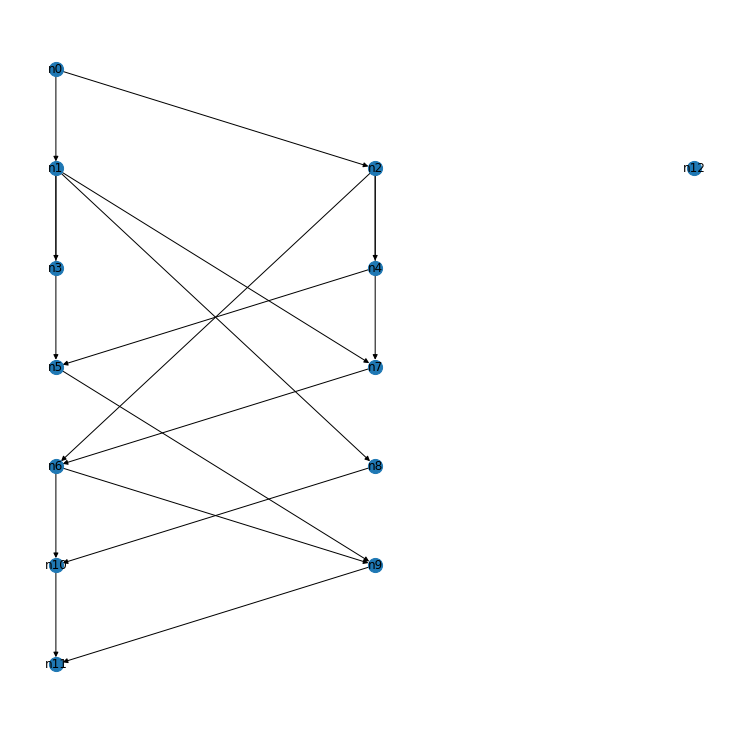

In [12]:
plt.figure(figsize=(10,10))
pos = coffman_graham_pos(L)
nx.draw(DAG, pos=pos, with_labels=True, node_size=200)
pylab.show()

    После укладки по слоям требуется добавить нужно число dummy-вершин и минимизировать (эвристическими средствами) количество пересечений рёбер, идущих между соседними слоями

In [13]:
def get_lvl(dict, search_value):
#     return dict.keys()[dict.values().index(data_x(search_age))]
    return [key for key, val in dict.items() if search_value in val][0]

In [14]:
def add_dummy_vert(DAG, layers):       
    count_layers = len(layers)
        
    for layer in list(layers.keys())[:count_layers - 2]:
        for vert in L[layer]:
            lvl_vert = layer
            _, parents = get_neighbors(DAG, vert)
            for parent in parents:
                lvl_parent = get_lvl(L, parent) #parent.lvl_vert(layers)
                lvl_diff = lvl_parent - lvl_vert
                if lvl_diff > 1:
                    lvl_dummy = lvl_vert + 1                    
                    name_dummy = f"dummy_{lvl_dummy}_{len(layers[lvl_dummy])}"
                    layers[lvl_dummy].append(name_dummy)
                    DAG.add_edge(parent, name_dummy)
                    DAG.add_edge(name_dummy, vert)
                    DAG.remove_edge(parent, vert)
                        
    return L

In [15]:
DAG = nx.read_graphml("unnamed.graphml")
v, L = coffman_graham(DAG)
L_dummy = add_dummy_vert(DAG, L)

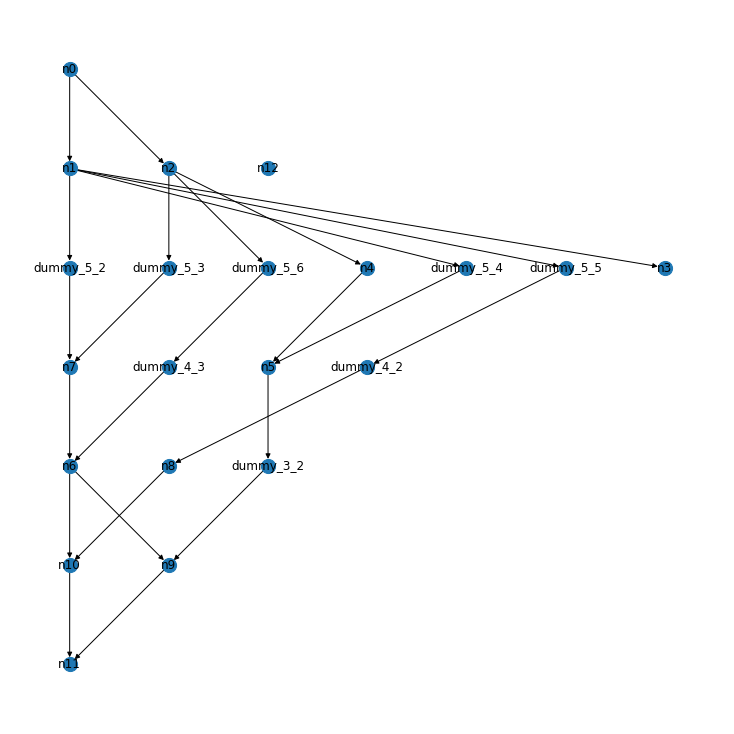

In [16]:
plt.figure(figsize=(10,10))
pos = coffman_graham_pos(L_dummy)
nx.draw(DAG, pos=pos, with_labels=True, node_size=200)
pylab.show()

In [18]:
def average_xcoordinate_parents(L, vert, layer, pos):
        _, parents = get_neighbors(DAG, vert)
        parent_in_layer = [parent for parent in parents if parent in layer]
        if len(parent_in_layer) > 0:
            average_x = sum([ pos[parent][0] for parent in parent_in_layer])/len(parent_in_layer)
            return int(average_x)
        else:
            return pos[vert][0]

from statistics import median
def median_xcoordinate_parents(L, vert, layer, pos):
        _, parents = get_neighbors(DAG, vert)
        parent_in_layer = [parent for parent in parents if parent in layer]
        if len(parent_in_layer) > 0:
            median_x = median([pos[parent][0] for parent in parent_in_layer])
            return int(median_x)
        else:
            return pos[vert][0]

In [19]:
import copy

In [20]:
def minimization_crossing(DAG, layers, position, type_x_pos="median"):
    pos = copy.deepcopy(position)
    count_layers = len(layers)
    for layer in list(layers.keys())[:count_layers - 1 ]:
        if type_x_pos == "median":
            values = sorted(layers[layer], key = lambda vert: median_xcoordinate_parents(L, vert, layers[layer + 1], pos))
        else:
            values = sorted(layers[layer], key = lambda vert: average_xcoordinate_parents(L, vert, layers[layer + 1], pos))
        for idx, v in enumerate(values):
            old_pos = pos[v]
            pos[v] = (idx, old_pos[1])
            
    return pos


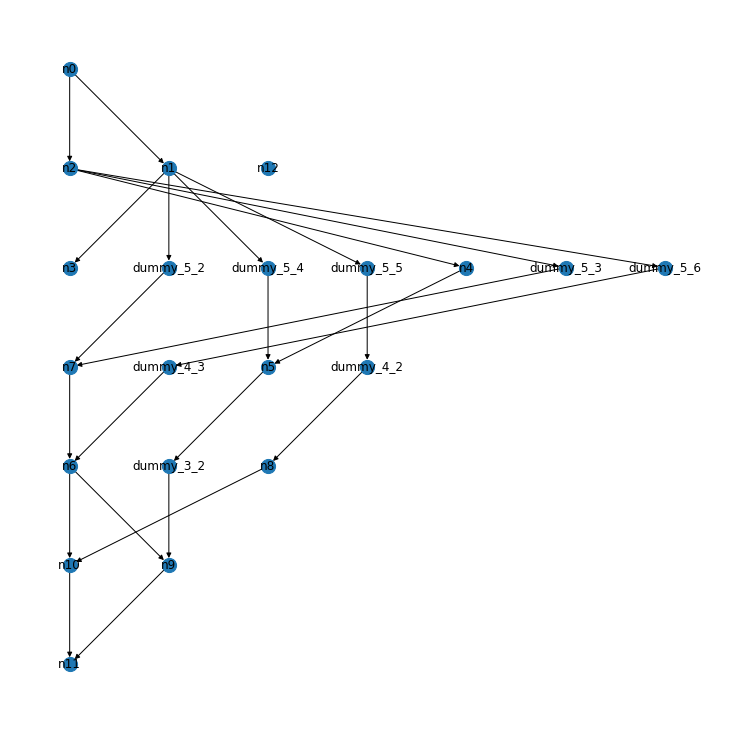

In [21]:
plt.figure(figsize=(10,10))
pos = minimization_crossing(DAG, L_dummy, pos, type_x_pos="avg")
nx.draw(DAG, pos=pos, with_labels=True, node_size=200)
pylab.show()

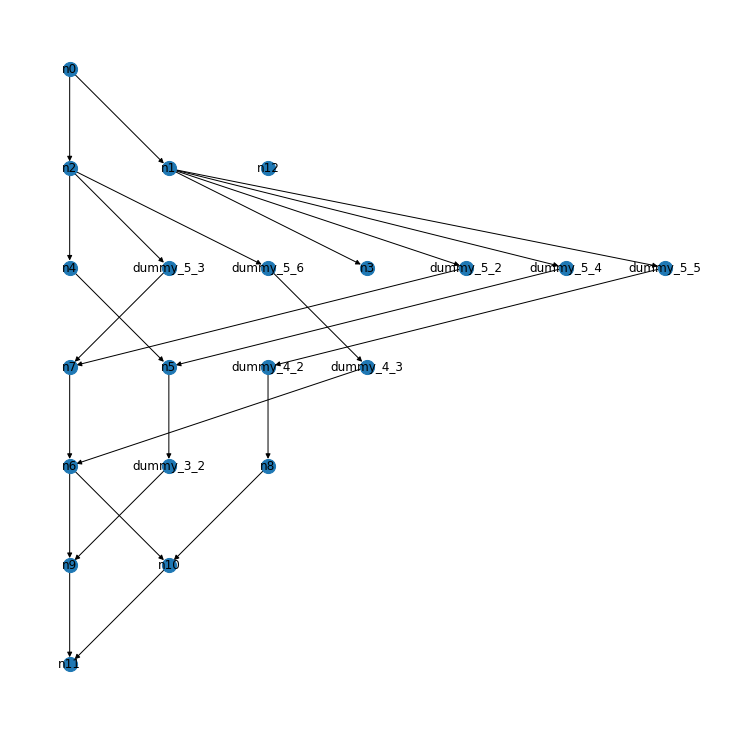

In [22]:
plt.figure(figsize=(10,10))
pos = minimization_crossing(DAG, L_dummy, pos, "median")
nx.draw(DAG, pos=pos, with_labels=True, node_size=200)
pylab.show()